# Main analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'
xkeys_plt = [  # Input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]

### Derived parameters

In [4]:
# Get batch-related settings
_, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, None, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
figs_suffix = f'{figs_suffix}_{errprop}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 27/09/2023 17:56:03: assembling batch analysis settings...
 27/09/2023 17:56:03: main analysis notebook started on 2023-09-27 at 17:56:03


### Input summary table figure

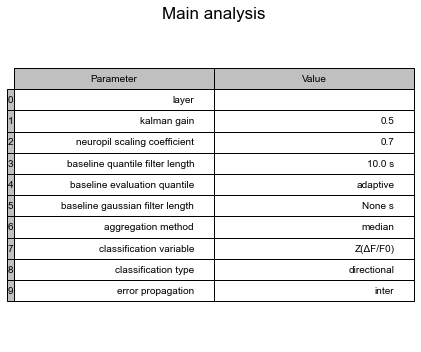

In [5]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Main analysis', aspect=1.5)

### Load data

In [6]:
stats, counts = load_lineagg_data(input_dir, errprop=errprop)
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats_all = stats[isall].droplevel(Label.ROI_RESP_TYPE)
stats_by_rtype = stats[~isall]
stats_pos = stats_by_rtype.loc[pd.IndexSlice[:, 'positive', :]]

 27/09/2023 17:56:03: input folder: /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main
 27/09/2023 17:56:03: loading line-average data (with inter-propagated SE)
 27/09/2023 17:56:03: line-aggregated data successfully loaded for lines ['line3' 'pv' 'sst']


### Plot responder type distribution per mouse line

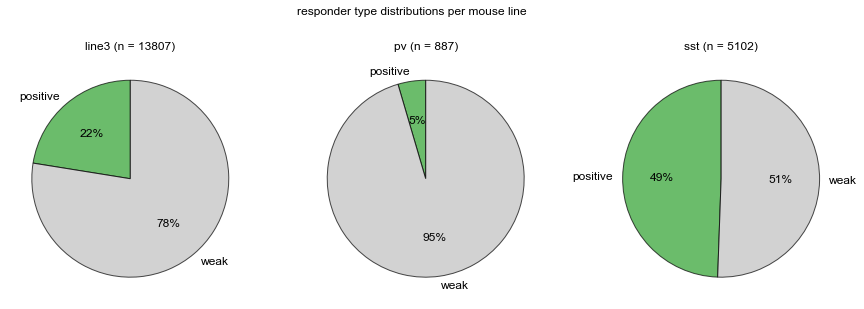

In [7]:
# Plot counts on pie chart
groups = stats_by_rtype.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = gdata['count'].groupby(Label.ROI_RESP_TYPE).first()
    ax.set_title(f'{line} (n = {counts[line].sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, ylabel='', autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Plot P, DC and Ispta parameter dependency curves, with fits

 27/09/2023 17:56:04: plotting evoked ΔF/F0 change vs. P (MPa) dependency profile for line3 line
 27/09/2023 17:56:04: fitting order 2 polynomial to data
 27/09/2023 17:56:04: fitting results: popt = [0.042, -0.0047, 0.0022], R2 = 0.95
 27/09/2023 17:56:04: fit parameter standard errors: [0.015, 0.012, 0.0017]
 27/09/2023 17:56:04: computing fit uncertainty with 1000 Monte Carlo simulations
 27/09/2023 17:56:04: plotting evoked ΔF/F0 change vs. P (MPa) dependency profile for pv line
 27/09/2023 17:56:04: fitting order 2 polynomial to data
 27/09/2023 17:56:04: fitting results: popt = [0.062, -0.04, 0.0042], R2 = 0.50
 27/09/2023 17:56:04: fit parameter standard errors: [0.036, 0.029, 0.0039]
 27/09/2023 17:56:04: computing fit uncertainty with 1000 Monte Carlo simulations
 27/09/2023 17:56:04: plotting evoked ΔF/F0 change vs. P (MPa) dependency profile for sst line
 27/09/2023 17:56:04: fitting order 2 polynomial to data
 27/09/2023 17:56:04: fitting results: popt = [0.15, -0.032, 0.00

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/tlemaire/Documents/code/usnm2p/utils.py:798: RuntimeWarning: overflow encountered in exp
  norm_sig = 1 / (1 + np.exp(-(x - x0) / sigma))


 27/09/2023 17:56:04: fit parameter standard errors: [0.88, 0.61, 0.0051]
 27/09/2023 17:56:04: computing fit uncertainty with 1000 Monte Carlo simulations
 27/09/2023 17:56:05: plotting evoked Z(ΔF/F0) change vs. P (MPa) dependency profile for line3 line
 27/09/2023 17:56:05: fitting order 2 polynomial to data
 27/09/2023 17:56:05: fitting results: popt = [2.7, -0.35, 0.15], R2 = 0.96
 27/09/2023 17:56:05: fit parameter standard errors: [0.9, 0.73, 0.098]
 27/09/2023 17:56:05: computing fit uncertainty with 1000 Monte Carlo simulations
 27/09/2023 17:56:05: plotting evoked Z(ΔF/F0) change vs. P (MPa) dependency profile for pv line
 27/09/2023 17:56:05: fitting order 2 polynomial to data
 27/09/2023 17:56:05: fitting results: popt = [4.6, -3.1, 0.33], R2 = 0.55
 27/09/2023 17:56:05: fit parameter standard errors: [2.3, 1.9, 0.25]
 27/09/2023 17:56:05: computing fit uncertainty with 1000 Monte Carlo simulations
 27/09/2023 17:56:05: plotting evoked Z(ΔF/F0) change vs. P (MPa) dependency

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


 27/09/2023 17:56:05: fitting results: popt = [-61, -8.5, -1.2], R2 = -0.00
 27/09/2023 17:56:05: unreliable fit (R2 = -0.00 > 0.50) -> ignoring
 27/09/2023 17:56:05: plotting evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) dependency profile for sst line
 27/09/2023 17:56:05: computing fit with sigmoid function: p0 = [5.4, 7.9, 4.2]
 27/09/2023 17:56:05: fitting results: popt = [4.9, 1.9, 3.6], R2 = 0.94
 27/09/2023 17:56:05: fit parameter standard errors: [0.54, 0.39, 0.23]
 27/09/2023 17:56:05: computing fit uncertainty with 1000 Monte Carlo simulations


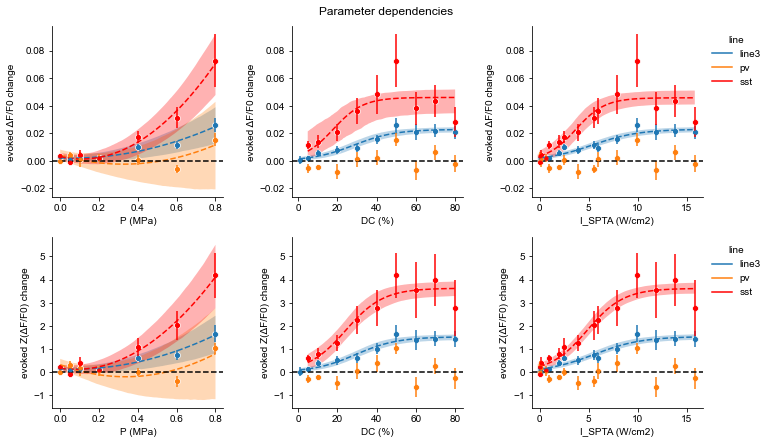

In [8]:
# Independent parameters
xkeys = [
    Label.P,
    Label.DC,
    Label.ISPTA,
]

# Dependent response variables
ykeys = [
    get_change_key(Label.DFF),
    get_change_key(Label.ZSCORE),
    # Label.RESP_FRAC,
]

figs[f'simparams_deps'] = plot_parameter_dependency_across_lines(
    stats_all.copy(),
    xkeys,
    ykeys,
    lw=0,
    marker='o',
    err_style='bars',
    fit=fit_dict,
    fit_ci=0.67,
)
figs[f'simparams_deps'].suptitle('Parameter dependencies', y=1.02);

### Plot P - DC alignment for various dose projections, for each mouse line

 27/09/2023 17:56:06: Processing line3 line
 27/09/2023 17:56:06: computing fit with sigmoid function: p0 = [0.27, 0.32, 1.7]
 27/09/2023 17:56:06: fitting results: popt = [0.23, 0.089, 1.5], R2 = 0.94
 27/09/2023 17:56:06: computing fit with sigmoid function: p0 = [6.6, 7.9, 1.7]
 27/09/2023 17:56:06: fitting results: popt = [5.8, 2.2, 1.5], R2 = 0.94
 27/09/2023 17:56:06: computing fit with sigmoid function: p0 = [8.5, 7.7, 1.7]
 27/09/2023 17:56:06: fitting results: popt = [9.3, 2.2, 1.6], R2 = 0.93
 27/09/2023 17:56:06: Processing pv line
 27/09/2023 17:56:06: computing fit with sigmoid function: p0 = [0.29, 0.32, 1]
 27/09/2023 17:56:06: convergence error during fitting
 27/09/2023 17:56:06: computing fit with sigmoid function: p0 = [7.2, 7.9, 1]
 27/09/2023 17:56:06: convergence error during fitting
 27/09/2023 17:56:06: computing fit with sigmoid function: p0 = [9.2, 7.7, 1]


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


 27/09/2023 17:56:07: fitting results: popt = [9.5, 0.078, 0.16], R2 = 0.06
 27/09/2023 17:56:07: unreliable fit (R2 = 0.06 > 0.50)
 27/09/2023 17:56:07: Processing sst line
 27/09/2023 17:56:07: computing fit with sigmoid function: p0 = [0.29, 0.32, 4.2]
 27/09/2023 17:56:07: fitting results: popt = [0.2, 0.076, 3.6], R2 = 0.91
 27/09/2023 17:56:07: computing fit with sigmoid function: p0 = [7.2, 7.9, 4.2]
 27/09/2023 17:56:07: fitting results: popt = [4.8, 1.9, 3.6], R2 = 0.91


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 27/09/2023 17:56:07: computing fit with sigmoid function: p0 = [9.2, 7.7, 4.2]
 27/09/2023 17:56:07: fitting results: popt = [8.3, 1.8, 3.7], R2 = 0.90


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


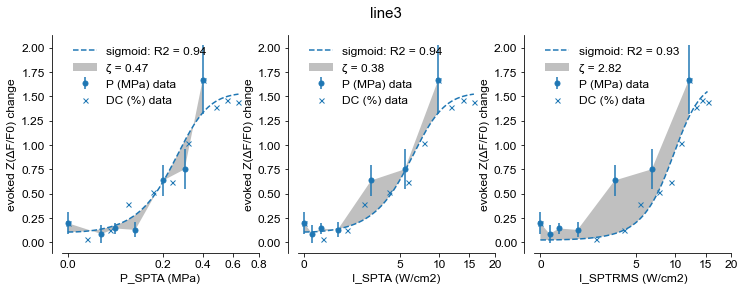

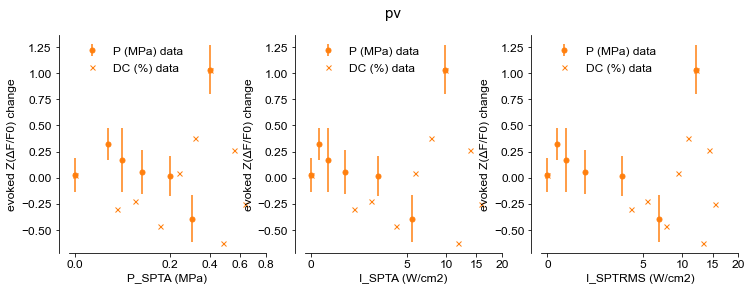

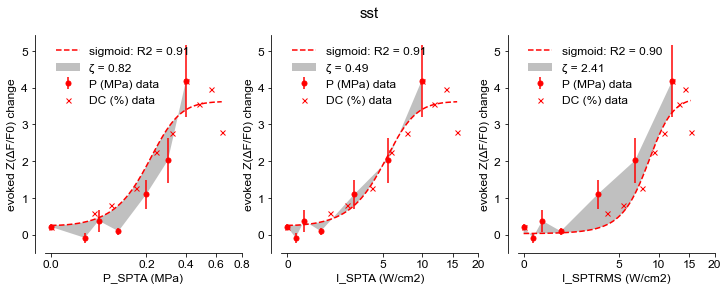

In [9]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Dependent response variables
fit_ykeys = [
    get_change_key(Label.ZSCORE)
]

# For each line
for line, gstats in stats_all.groupby(Label.LINE):
    logger.info(f'Processing {line} line')
    # For each output metrics
    for ykey_diff in fit_ykeys:
        # Evaluate and plot alignment between DC sweep predictor and P sweep data
        figs[f'{line} {ykey_diff} fits'] = plot_response_alignment(
            gstats, 
            xkeys, 
            ykey_diff, 
            fit_dict, 
            xscale='sqrt', 
            height=4,
            title=line,
        )

### Plot average cell density per line

 27/09/2023 17:56:08: computing cell densities from cell counts
 27/09/2023 17:56:08: plotting cell densities across lines


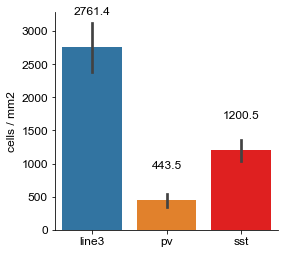

In [10]:
# Compute cell densities from cell counts
logger.info('computing cell densities from cell counts')
Lx = Ly = .5  # FOV dimensions (mm)
fov_area = Lx * Ly  # mm2
densities = (counts / fov_area).rename(Label.ROI_DENSITY)

# Plot average cell densities
logger.info('plotting cell densities across lines')
fs = 12
fig, ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
sns.barplot(
    data=densities.reset_index(), 
    ax=ax, 
    x=Label.LINE, 
    y=Label.ROI_DENSITY,
    palette=Palette.LINE,
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', fontsize=fs, padding=30)
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(fs)
ax.set_xlabel(None)
ax.set_ylabel(Label.ROI_DENSITY, fontsize=fs);

### Define E/I roles and factors for each cell type in the circuit

In [11]:
cellstats = densities.groupby(Label.LINE).mean().to_frame()
cellstats['factor'] = cellstats[Label.ROI_DENSITY] / cellstats[Label.ROI_DENSITY].max()
cellstats['type'] = {
    'line3': 'E',
    'sst': 'I',
    'pv': 'I',
}
cellstats['sign'] = cellstats['type'].map({'E': 1, 'I': -1})
cellstats['prefix'] = cellstats['type'].map({'E': '+', 'I': '-'})
cellstats

,cells / mm2,factor,type,sign,prefix
line,,,,,
line3,2761.400000,1.000000,E,1,+
pv,443.500000,0.160607,I,-1,-
sst,1200.470588,0.434733,I,-1,-


### Plot nominal and scaled responses per mouse line, and net circuit effect

 27/09/2023 17:56:08: extracting, computing, and scaling line3 responses
 27/09/2023 17:56:08: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 27/09/2023 17:56:08: computing fit with sigmoid function: p0 = [5.1, 7.9, 0.026]
 27/09/2023 17:56:08: fitting results: popt = [5.4, 2.4, 0.023], R2 = 0.92
 27/09/2023 17:56:08: fit parameter standard errors: [0.75, 0.5, 0.0019]
 27/09/2023 17:56:08: computing fit uncertainty with 1000 Monte Carlo simulations
 27/09/2023 17:56:08: extracting, computing, and scaling pv responses
 27/09/2023 17:56:08: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 27/09/2023 17:56:08: computing fit with sigmoid function: p0 = [5.4, 7.9, 0.015]
 27/09/2023 17:56:08: fitting results: popt = [-25, -2.3, 0.0037], R2 = -0.00
 27/09/2023 17:56:08: Failed to fit pv data: unreliable fit (R2 = -0.00 > 0.50)
 27/09/2023 17:56:08: extracting, computing, and scaling sst responses
 27/09/2023 17:56:08: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -

/Users/tlemaire/Documents/code/usnm2p/utils.py:798: RuntimeWarning: overflow encountered in exp
  norm_sig = 1 / (1 + np.exp(-(x - x0) / sigma))


 27/09/2023 17:56:08: fitting results: popt = [-61, -8.4, -1.2], R2 = -0.00
 27/09/2023 17:56:08: Failed to fit pv data: unreliable fit (R2 = -0.00 > 0.50)
 27/09/2023 17:56:08: extracting, computing, and scaling sst responses
 27/09/2023 17:56:08: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 27/09/2023 17:56:08: computing fit with sigmoid function: p0 = [5.4, 7.9, 4.2]
 27/09/2023 17:56:08: fitting results: popt = [4.9, 1.9, 3.6], R2 = 0.94
 27/09/2023 17:56:08: fit parameter standard errors: [0.54, 0.39, 0.23]
 27/09/2023 17:56:08: computing fit uncertainty with 1000 Monte Carlo simulations


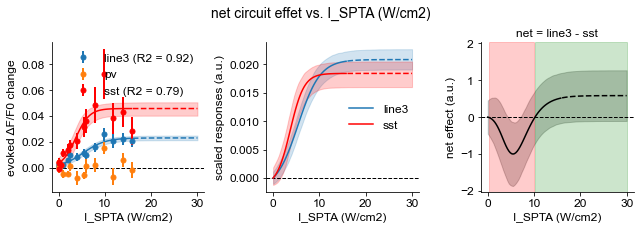

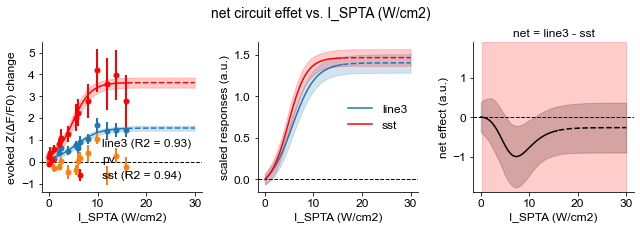

In [12]:
# Input parameter and its max value
xkey = Label.ISPTA
xmax = 30.

# Dependent response variables
ykeys = [
    get_change_key(Label.DFF), 
    get_change_key(Label.ZSCORE)
]

# For each response variable, plot circuit effect
for ykey in ykeys:
    fig = plot_circuit_effect(
        stats_all, 
        cellstats, 
        xkey, 
        ykey, 
        ci=.67,
        xmax=xmax,
        fit='sigmoid',
        add_net_color=True,
    )

### Save figures

In [13]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 27/09/2023 17:56:09: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.09.27/figs_main_all_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional_inter.pdf:


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


### Notify upon completion

In [14]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 27/09/2023 17:56:10: main analysis notebook completed in 0:00:07.264081 s
